# Subset the IS2 and Lidar data for point cloud alignment

In [25]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as cx
from matplotlib_scalebar.scalebar import ScaleBar
from astropy.time import Time
from datetime import datetime
import rasterio as rio
from rasterio import features
from rasterio.plot import show
import rasterio.windows
from rasterio.windows import from_bounds
from rasterio.enums import Resampling
import rioxarray as rxr
from shapely.geometry import Polygon
from shapely.geometry import mapping

In [2]:
%matplotlib inline

In [3]:
atl06sr_snowoff_fn = '../data/methow_snowoff_sr-atl0604272022_32610.geojson'
atl06sr_snowoff = gpd.read_file(atl06sr_snowoff_fn) #, geometry=gpd.points_from_xy(atl06sr_snowoff.x, atl06sr_snowoff.y)

In [4]:
atl06sr_snowoff.crs

<Projected CRS: EPSG:32610>
Name: WGS 84 / UTM zone 10N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 126°W and 120°W, northern hemisphere between equator and 84°N, onshore and offshore. Canada - British Columbia (BC); Northwest Territories (NWT); Nunavut; Yukon. United States (USA) - Alaska (AK).
- bounds: (-126.0, 0.0, -120.0, 84.0)
Coordinate Operation:
- name: UTM zone 10N
- method: Transverse Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

<AxesSubplot:>

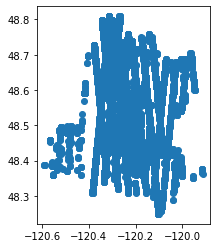

In [52]:
atl06sr_snowoff.plot()

In [7]:
atl06sr_snowoff.head()

,x,y,z,geometry
0,-120.5514889,48.35915778,2064.199461,None
1,-120.5515161,48.35933674,2054.374982,None
2,-120.5515433,48.35951602,2046.90207,None
3,-120.5515706,48.3596953,2041.548979,None
4,-120.551598,48.35987457,2039.899003,None


In [5]:
asp_area_fn = '../data/asp_area.geojson'
asp_area = gpd.read_file(asp_area_fn)

In [6]:
asp_area = asp_area.to_crs('epsg:32610')

<AxesSubplot:>

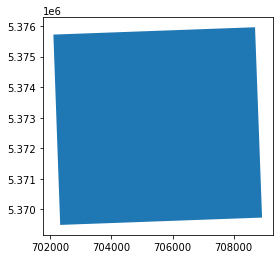

In [68]:
asp_area.plot()

In [7]:
asp_area.bounds

,minx,miny,maxx,maxy
0,702103.278184,5.369496e+06,708926.081779,5.375959e+06


In [8]:
bounds = [(702103.278184, 5.369496e+06), (702103.278184, 5.375959e+06), (708926.081779, 5.375959e+06), (708926.081779, 5.369496e+06), (702103.278184, 5.369496e+06)]
polygon = Polygon([(702103.278184, 5.369496e+06), (702103.278184, 5.375959e+06), (708926.081779, 5.375959e+06), (708926.081779, 5.369496e+06), (702103.278184, 5.369496e+06)])

In [10]:
poly_gdf = gpd.GeoDataFrame([1], geometry=[polygon], crs=atl06sr_snowoff.crs)

In [11]:
poly_gdf.crs

<Projected CRS: EPSG:32610>
Name: WGS 84 / UTM zone 10N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 126°W and 120°W, northern hemisphere between equator and 84°N, onshore and offshore. Canada - British Columbia (BC); Northwest Territories (NWT); Nunavut; Yukon. United States (USA) - Alaska (AK).
- bounds: (-126.0, 0.0, -120.0, 84.0)
Coordinate Operation:
- name: UTM zone 10N
- method: Transverse Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

<AxesSubplot:>

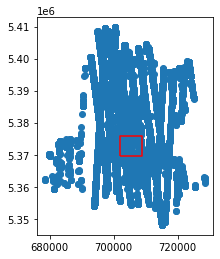

In [12]:
fig, ax = plt.subplots()

atl06sr_snowoff.plot(ax = ax)
poly_gdf.boundary.plot(ax = ax, color="red")

In [13]:
type(atl06sr_snowoff)

geopandas.geodataframe.GeoDataFrame

In [14]:
snowoff_subset = gpd.clip(atl06sr_snowoff, poly_gdf)

<AxesSubplot:>

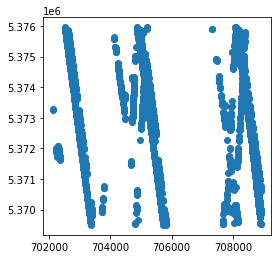

In [14]:
snowoff_subset.plot()

### Using rasterio windows, also from David's GDA notebook: 05 Raster1 Part 2.

In [36]:
dnr_fn = '../../datasetsA/methow_basin_2018/dtm/raw/methow_basin_2018_dtm_combined_32610_1m.tif'
dnr_fn_10m = '../../datasetsA/methow_basin_2018/dtm/raw/methow_basin_2018_dtm_combined_32610_10m.tif'

In [35]:
src = rio.open(dnr_fn_10m)

In [23]:
asp_area.bounds

,minx,miny,maxx,maxy
0,702103.278184,5.369496e+06,708926.081779,5.375959e+06


In [24]:
left = 702103.278184
bottom = 5.369496e+06
right = 708926.081779
top = 5.375959e+06

In [44]:
# bottom = bounds[0] 
# left = bounds[1] 
# top = bounds[2]
# right = bounds[3]

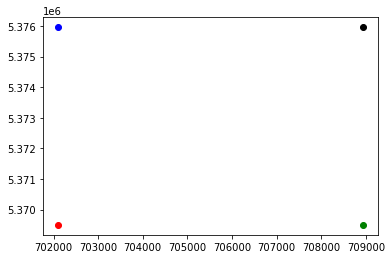

In [45]:
fig, ax = plt.subplots()
ax.scatter(left[0], left[1], c = 'b')
ax.scatter(bottom[0], bottom[1], c = 'r')
ax.scatter(right[0], right[1], c = 'g')
ax.scatter(top[0], top[1], c = 'k')

In [32]:
#Define window bounds
window = rasterio.windows.from_bounds(left, bottom, right, top, transform = src_proj.transform)
window_bounds = rasterio.windows.bounds(window, transform = src_proj.transform)
print("Window bounds: ", window_bounds)
#Define window extent
window_extent = [window_bounds[0], window_bounds[2], window_bounds[1], window_bounds[3]]
print("Window extent: ", window_extent)

Window bounds:  (702103.278184, 5369496.0, 708926.0817790001, 5375959.0)
Window extent:  [702103.278184, 708926.0817790001, 5369496.0, 5375959.0]


In [52]:
with rio.open('../../datasetsA/methow_basin_2018/dtm/raw/methow_basin_2018_dtm_combined_32610_1m.tif', 
            'w', 
             driver='GTiff',
             height = src.height,
             width = src.width,
             count = 1,
             dtype = a.dtype,
             crs = src.crs,
             transform = src.transform) as src:
    a = src.read(1, window=window) # , masked = True
    a.write(1)

UnsupportedOperation: not readable

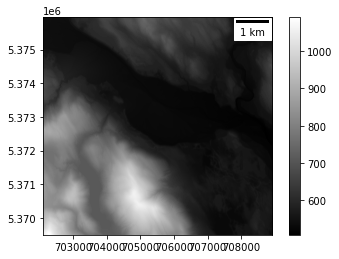

In [39]:
f,ax = plt.subplots()
plt.imshow(a, cmap='gray', extent=window_extent)
plt.colorbar()
ax.add_artist(ScaleBar(1));

In [40]:
type(a)

numpy.ndarray

In [45]:
src.width

59756

In [49]:
a.dtype

dtype('float32')

In [51]:
src.dtype()

AttributeError: 'DatasetReader' object has no attribute 'dtype'